# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding

# Data Understanding

## Data preparation

In [1]:
# For Google Colab only
# Cell output cleared as it only contains installation progress information
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.1 MB/s eta 0:00:00


In [2]:
# Importing tools and modules for data preperation
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import splitfolders

In [3]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [4]:
# Downloading kaggle dataset
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Making parent folder directory before data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/brain_tumor_dataset/meningioma/meningioma515.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma516.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma517.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma518.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma519.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma52.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma520.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma521.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma522.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma523.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma524.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma525.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma526.png  
 

In [5]:
# Splitting data into train data, test data, validation data directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15,0.15))

Copying files: 10560 files [00:10, 1028.97 files/s]


In [6]:
# Creating directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [7]:
# Variable to rescale data as its being imported
datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Importing brain tumor image data
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=32,
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=32,
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=32,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [9]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [10]:
# Add some data exploration stuff

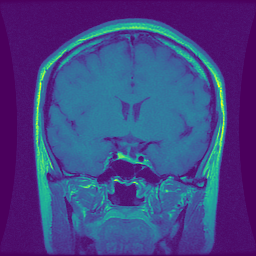

In [11]:
array_to_img(train_images[2])

# Modeling

In [12]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [13]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [14]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [15]:
data_dict = {
    'Train Data': (train_images, train_labels),
    'Val Data': (val_images, val_labels)
}

### CNN Model

In [16]:
base_cnn = Sequential()

In [17]:
base_cnn.add(layers.Input(shape=(256, 256, 3)))
base_cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(64, activation='relu'))
base_cnn.add(layers.Dense(4, activation='softmax'))

In [18]:
base_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
base_cnn_results = base_cnn.fit(train_images, train_labels,
                                epochs=10,
                                validation_data=(val_images, val_labels))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2500 - loss: 1.4053 - val_accuracy: 0.3750 - val_loss: 4.3021
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4062 - loss: 3.3210 - val_accuracy: 0.2812 - val_loss: 8.6927
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3125 - loss: 6.1712 - val_accuracy: 0.3750 - val_loss: 3.0572
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 1.7828 - val_accuracy: 0.3125 - val_loss: 1.4505
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.3438 - loss: 1.0356 - val_accuracy: 0.2188 - val_loss: 1.5334
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5625 - loss: 1.1983 - val_accuracy: 0.5000 - val_loss: 1.4515
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7188 - loss: 1.0492 - val_accuracy: 0.4375 - val_loss: 1.3100
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7500 - loss: 0.8375 - val_accuracy: 0.4688 - val_loss: 1.1706
Epoch 9/10
1/1 ━

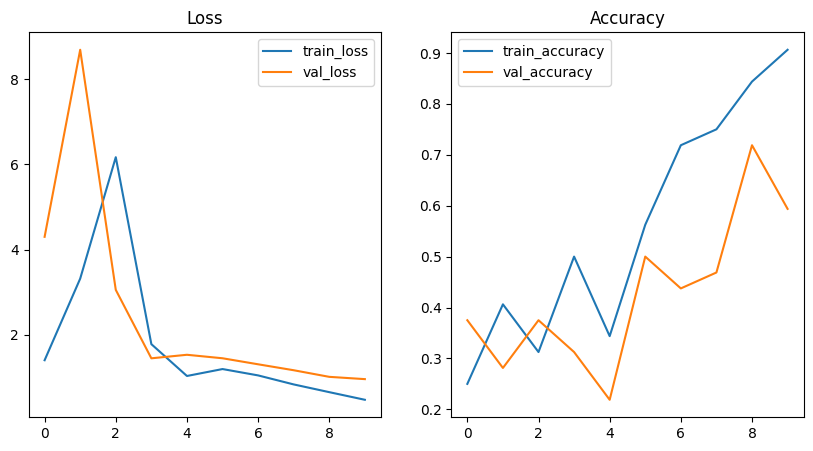

In [21]:
plot_results([base_cnn_results])

In [24]:
model_evaluation(base_cnn, data_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step - accuracy: 0.9688 - loss: 0.3847
Train Data, Loss: 0.3847, Accuracy: 0.9688
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step - accuracy: 0.5938 - loss: 0.9618
Val Data, Loss: 0.9618, Accuracy: 0.5938


### DenseNet Model

In [34]:
dn_base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [35]:
base_densenet = Sequential()
base_densenet.add(dn_base_model)
base_densenet.add(layers.GlobalAveragePooling2D())
base_densenet.add(layers.Dense(64, activation='relu'))
base_densenet.add(layers.Dropout(0.5))
base_densenet.add(layers.Dense(4, activation='softmax'))

In [36]:
base_densenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [37]:
base_densenet_results = base_densenet.fit(train_images, train_labels,
                                          epochs=10,
                                          validation_data=(val_images, val_labels))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 147s 147s/step - accuracy: 0.3125 - loss: 1.6548 - val_accuracy: 0.3750 - val_loss: 2.0366
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.7500 - loss: 0.6500 - val_accuracy: 0.4375 - val_loss: 2.1412
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 0.9375 - loss: 0.3451 - val_accuracy: 0.4375 - val_loss: 2.2354
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 79s 79s/step - accuracy: 0.8125 - loss: 0.4224 - val_accuracy: 0.4062 - val_loss: 2.7876
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step - accuracy: 0.9375 - loss: 0.2474 - val_accuracy: 0.3438 - val_loss: 2.5268
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step - accuracy: 0.9062 - loss: 0.2322 - val_accuracy: 0.5000 - val_loss: 1.5091
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 1.0000 - loss: 0.0625 - val_accuracy: 0.6250 - val_loss: 1.4330
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step - accuracy: 1.0000 - loss: 0.0731 - val_accuracy: 0.4375 - val_loss: 2.090

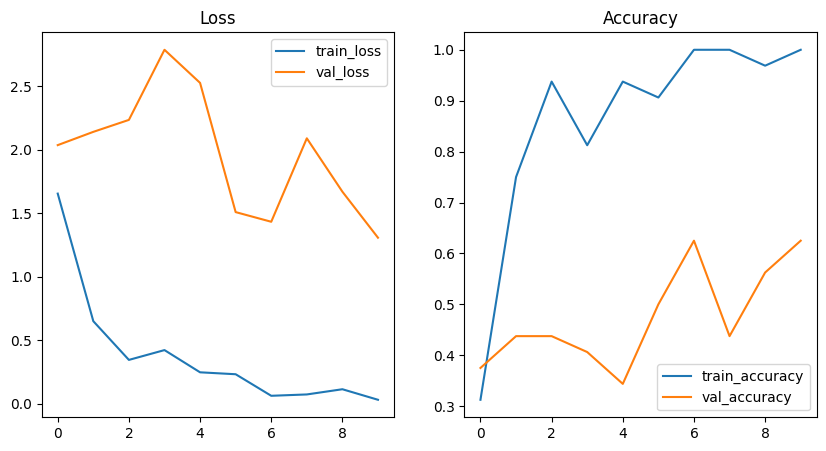

In [38]:
plot_results([base_densenet_results])

In [39]:
model_evaluation(base_densenet, data_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5938 - loss: 1.6414
Train Data, Loss: 1.6414, Accuracy: 0.5938
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6250 - loss: 1.3075
Val Data, Loss: 1.3075, Accuracy: 0.6250


### ResNet Model

In [49]:
rn_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [53]:
base_resnet = Sequential()
base_resnet.add(rn_base_model)
base_resnet.add(layers.GlobalAveragePooling2D())
base_resnet.add(layers.Dense(64, activation='relu'))
base_resnet.add(layers.Dropout(0.5))
base_resnet.add(layers.Dense(4, activation='softmax'))

In [54]:
base_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [55]:
base_resnet_results = base_resnet.fit(train_images, train_labels,
                                      epochs=10,
                                      validation_data=(val_images, val_labels))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 103s 103s/step - accuracy: 0.2812 - loss: 1.9963 - val_accuracy: 0.2500 - val_loss: 1.4515
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.6875 - loss: 1.3193 - val_accuracy: 0.3750 - val_loss: 2.4262
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.9062 - loss: 0.2911 - val_accuracy: 0.0938 - val_loss: 4.4183
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 80s 80s/step - accuracy: 0.9375 - loss: 0.1738 - val_accuracy: 0.2500 - val_loss: 9.3626
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 1.0000 - loss: 0.0687 - val_accuracy: 0.2500 - val_loss: 30.2019
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 81s 81s/step - accuracy: 1.0000 - loss: 0.0543 - val_accuracy: 0.2500 - val_loss: 74.2118
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.9688 - loss: 0.0543 - val_accuracy: 0.2500 - val_loss: 112.6403
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - accuracy: 1.0000 - loss: 0.0437 - val_accuracy: 0.2500 - val_loss: 1

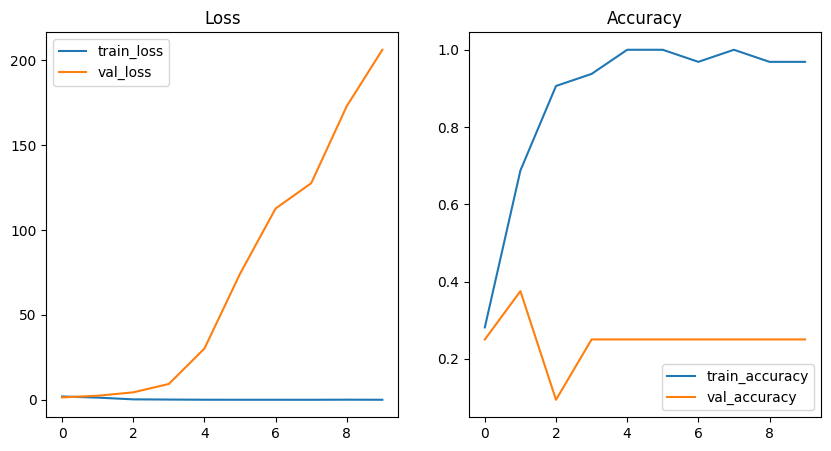

In [56]:
plot_results([base_resnet_results])

In [57]:
model_evaluation(base_resnet, data_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1875 - loss: 222.0033
Train Data, Loss: 222.0033, Accuracy: 0.1875
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2500 - loss: 206.0677
Val Data, Loss: 206.0677, Accuracy: 0.2500


# Evaluation

# Limitations

# Next Steps